In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
from ema_workbench import (Model, RealParameter, IntegerParameter, CategoricalParameter,
                           ScalarOutcome, perform_experiments, Samplers, Policy, Scenario, HypervolumeMetric,
                           GenerationalDistanceMetric, EpsilonIndicatorMetric, InvertedGenerationalDistanceMetric,
                           SpacingMetric)
from ema_workbench.em_framework import (SequentialEvaluator, MultiprocessingEvaluator)
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.optimization import (EpsNSGAII, Convergence)
from ema_workbench.analysis import parcoords
from dike_model_function import DikeNetwork
import matplotlib.pyplot as plt
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress)
import os
from ema_workbench.em_framework.optimization import to_problem
import seaborn as sns

# Define the sum_over function
def sum_over(*args):
    numbers = []
    for entry in args:
        try:
            value = sum(entry)
        except TypeError:
            value = entry
        numbers.append(value)
    return sum(numbers)

# Define the function to get the model for the given problem formulation
def get_model_for_problem_formulation(problem_formulation_id):
    function = DikeNetwork()
    dike_model = Model("dikesnet", function=function)

    Real_uncert = {"Bmax": [30, 350], "pfail": [0, 1]}  # m and [.]
    cat_uncert_loc = {"Brate": (1.0, 1.5, 10)}
    cat_uncert = {f"discount rate {n}": (1.5, 2.5, 3.5, 4.5) for n in function.planning_steps}
    Int_uncert = {"A.0_ID flood wave shape": [0, 132]}

    uncertainties = []

    for uncert_name in cat_uncert.keys():
        categories = cat_uncert[uncert_name]
        uncertainties.append(CategoricalParameter(uncert_name, categories))

    for uncert_name in Int_uncert.keys():
        uncertainties.append(IntegerParameter(uncert_name, Int_uncert[uncert_name][0], Int_uncert[uncert_name][1]))

    dike_height_levers = []
    for dike in function.dikelist:
        for uncert_name in Real_uncert.keys():
            name = f"{dike}_{uncert_name}"
            lower, upper = Real_uncert[uncert_name]
            uncertainties.append(RealParameter(name, lower, upper))

        for uncert_name in cat_uncert_loc.keys():
            name = f"{dike}_{uncert_name}"
            categories = cat_uncert_loc[uncert_name]
            uncertainties.append(CategoricalParameter(name, categories))

        for n in function.planning_steps:
            name = f"{dike}_DikeIncrease {n}"
            dike_height_levers.append(IntegerParameter(name, 0, 10))

    dike_model.uncertainties = uncertainties

    dike_height_levers.append(IntegerParameter("EWS_DaysToThreat", 0, 4))  # days
    # Set levers: No RfR, dike heightening
    dike_model.levers = dike_height_levers

    # Define the outcomes
    outcomes = [
        ScalarOutcome('Total Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist] +
                      [f"{dike}_Dike Investment Costs" for dike in function.dikelist] +
                      ["RfR Total Costs"]
        ),
        ScalarOutcome('Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Number of Deaths" for dike in function.dikelist]
        ),
        ScalarOutcome('Expected Annual Damage', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist]),
        ScalarOutcome('Dike Investment Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over,
                      variable_name=[f"{dike}_Dike Investment Costs" for dike in function.dikelist])
    ]

    dike_model.outcomes = outcomes

    return dike_model

# Get the model for a specific problem formulation
problem_formulation_id = 6  # Change this to the desired problem formulation
dike_model = get_model_for_problem_formulation(problem_formulation_id)

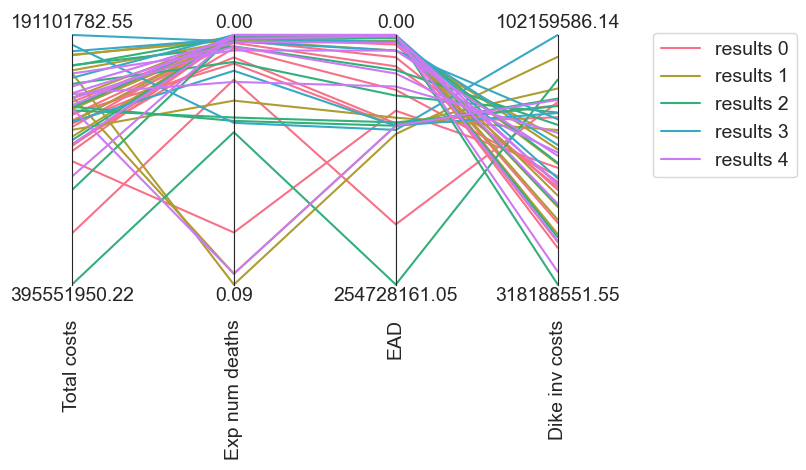

In [36]:
import pandas as pd
import seaborn as sns
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

# Load the optimization results
results = []
for i in range(5):
    result_df = pd.read_csv(f'optimization_outcomes_{i}.csv')
    results.append(result_df)

# Define the columns to plot
columns_to_plot = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']
custom_column_names = ['Total costs', 'Exp num deaths', 'EAD', 'Dike inv costs']

# Ensure the columns are present in the results
present_columns = []
for col in columns_to_plot:
    if all(col in result.columns for result in results):
        present_columns.append(col)

# Define limits based on the actual range of your outcomes
limits = pd.DataFrame({
    'min': [min(result[col].min() for result in results) for col in present_columns],
    'max': [max(result[col].max() for result in results) for col in present_columns]
}, index=present_columns).T

# Rename the limits DataFrame columns for better readability
limits.columns = custom_column_names

# Create parallel axes
axes = parcoords.ParallelAxes(limits)

# Plot each result set
for i, (result, color) in enumerate(zip(results, sns.color_palette("husl", 5))):
    outcomes = result[present_columns]
    outcomes.columns = custom_column_names  # Rename the outcomes columns for plotting
    axes.plot(outcomes, color=color, label=f'results {i}')

# Invert the axis for outcomes where lower values are better
for col in custom_column_names:
    axes.invert_axis(col)

# Add legend and display the plot
axes.legend()
plt.show()

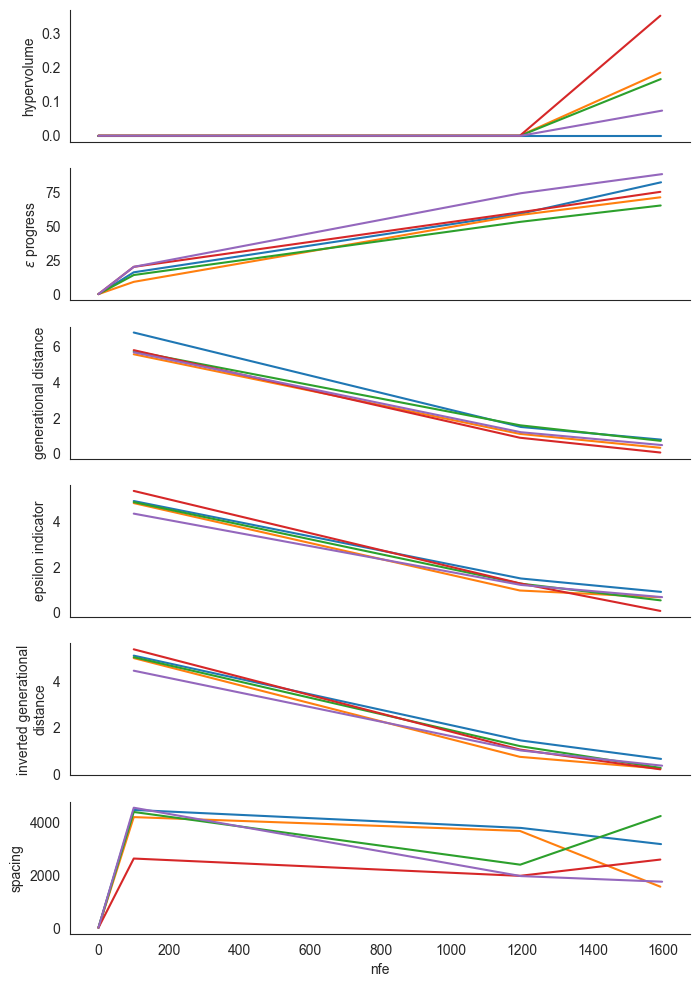

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.em_framework.optimization import ArchiveLogger, epsilon_nondominated
from ema_workbench import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.em_framework.optimization import to_problem, HypervolumeMetric, GenerationalDistanceMetric, EpsilonIndicatorMetric, InvertedGenerationalDistanceMetric, SpacingMetric
from dike_model_function import DikeNetwork

# Load archives
all_archives = []
for i in range(5):
    archives = ArchiveLogger.load_archives(f"./archives/{i}.tar.gz")
    for key in archives:
        if 'Unnamed: 0' in archives[key].columns:
            archives[key] = archives[key].drop('Unnamed: 0', axis=1)
    all_archives.append(archives)

# Load results from all runs
results = []
for i in range(5):
    result = pd.read_csv(f'optimization_policies_{i}.csv')
    results.append(result)

# Function to calculate metrics
def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
    

        # Handle infinite values
        for key in scores:
            if scores[key] == float('inf'):
                scores[key] = None

        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics

# Load convergence metrics from all runs
convergences = []
for i in range(5):
    convergence = pd.read_csv(f'convergence_metrics_{i}.csv')
    convergences.append(convergence)

# Define the problem and calculate the reference set
problem = to_problem(dike_model, searchover="levers")
results_concat = pd.concat(results, ignore_index=True)
reference_set = epsilon_nondominated([results_concat], epsilons=[0.1, 0.1, 0.1, 0.1], problem=problem)

# Calculate metrics for each seed
metrics_by_seed = []
for entry in all_archives:
    metrics = calculate_metrics(entry, reference_set)
    metrics_by_seed.append(metrics)

sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

ax1, ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence['nfe'], convergence['epsilon_progress'])
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")

sns.despine(fig)

plt.show()
